# Notebook 1 - Fuel property modeling

By Vincent Blay, November 2021

In this notebook we demonstrate the use of MACAW embeddings to describe molecules and train regression models of different molecular properties. The results illustrate the usefulness and speed of the approach and its compatibility with small and medium-sized datasets that are commonly found in the biosciences.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

import macaw
print(macaw.__version__)

from macaw import *
%run "./plotting.py"

0.1.13


In [4]:
%config InlineBackend.figure_format = 'retina'

## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [5]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


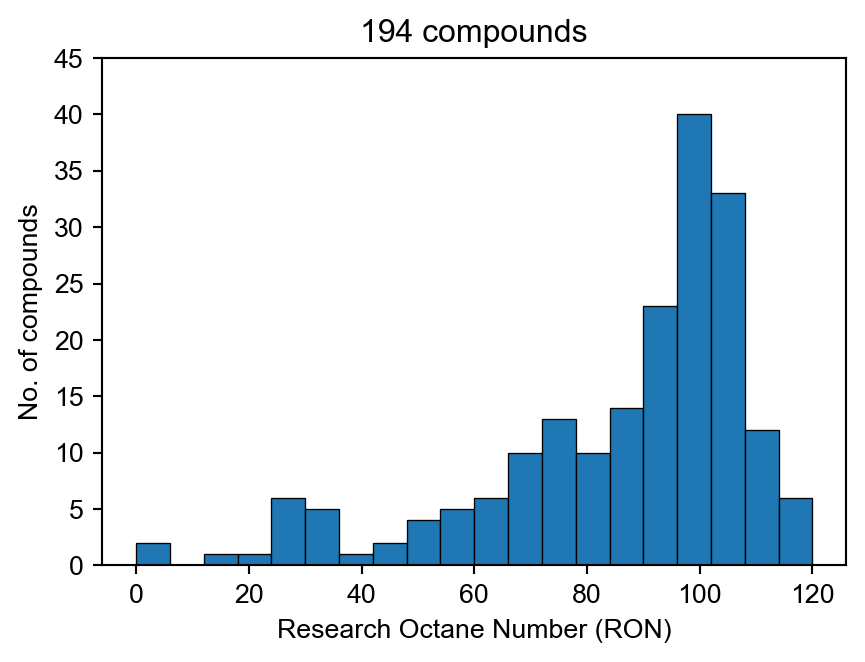

In [6]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us split the data in training and validation sets:

In [7]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

Compute the MACAW embeddings of the molecules is very easy. We just initialize the embedder:

In [8]:
mcw = MACAW(random_state=42)
mcw.fit(smi_train)

And then we project the training molecules:

In [9]:
X_train = mcw.transform(smi_train)
X_train[0:4]

array([[ 0.19884805,  0.2409601 , -0.06775784, -0.02118356,  0.01205462,
         0.0092095 , -0.01561448, -0.0151575 ,  0.04589545, -0.02675224,
         0.01445283,  0.0022183 ,  0.02020615, -0.00287598,  0.0334231 ],
       [-0.03861072, -0.07373147,  0.12948979,  0.16329053,  0.11389935,
         0.12492843,  0.17406906, -0.02258431,  0.11506867,  0.00436288,
         0.00761693, -0.07656237, -0.04965525, -0.0764287 , -0.00775711],
       [ 0.1488714 ,  0.07679446,  0.02132863, -0.02997206,  0.00108838,
        -0.01158404,  0.04001913, -0.03045062, -0.03971427,  0.01451947,
         0.00394997,  0.05331182, -0.01309209,  0.00505506,  0.02383794],
       [ 0.02841089, -0.18733468, -0.1250562 , -0.10074994,  0.03711881,
        -0.08807791, -0.16081502, -0.13302582, -0.09786195,  0.05021411,
         0.01384474,  0.03374984, -0.09693374,  0.0429507 ,  0.05853095]])

The fit and transform process can be done faster in one step using the `fit_transform` method.

A variety of fingerprints (`type_fp`) and similarity metrics (`metric`) are available and can be tuned to maximize the performance of the embedding for a given problem. The dimensionality of the embedding can be set using the `n_components` argument.

As an optional parameter, the property values can also be provided when fitting the embedder (`Y=y_train`). In this case, it will choose the landmark molecules more uniformly throughout the RON range. If not provided, landmark molecules are chosen randomly.

In [10]:
mcw = MACAW(type_fp='atompairs', metric='rogot-goldberg', n_components=15, n_landmarks=100, random_state=57)
X_train = mcw.fit_transform(smiles, Y=y_train)
X_train[0:4]

array([[-0.40130185,  0.08210583,  0.19027524, -0.164668  ,  0.0217731 ,
        -0.29688321,  0.03985101, -0.14683456,  0.11241473,  0.01223104,
         0.045353  ,  0.08147502, -0.05778315,  0.01017389, -0.04357766],
       [ 0.03606253, -0.13709874,  0.15647348,  0.05091909, -0.04166269,
         0.01842223,  0.1741296 ,  0.08845769, -0.07214221, -0.17079708,
         0.04743385,  0.0664307 ,  0.03586416,  0.00852211,  0.13308152],
       [ 0.04549525, -0.28584305, -0.08308062, -0.18802785,  0.30988297,
         0.18900348,  0.00656332, -0.02394803,  0.10900851, -0.13882069,
        -0.0670823 ,  0.16844191, -0.01884168,  0.2783186 , -0.18573517],
       [ 0.14818929, -0.18528988,  0.10278648, -0.25072034,  0.29944551,
         0.2546804 , -0.13569402, -0.11437833,  0.08961876, -0.00056613,
         0.16144403,  0.20385203, -0.11389405, -0.04488207, -0.06987032]])

In order to automate the selection of the `type_fp` and `metric`, we have implemented the function `MACAW_optimus`, which can help select a good combination. Internally, it explores a variety of embeddings by combining these hyperparameters and use them to train SVM models, which are assessed using cross_validation. The embedding leading to the best performing model is returned to the user.

In [11]:
mcw = MACAW_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100, random_state=57)

Problem type identified as regression
morgan2 & tanimoto: 0.508
morgan3 & tanimoto: 0.508
rdk5 & tanimoto: 0.596
rdk7 & tanimoto: 0.613
featmorgan2 & tanimoto: 0.559
featmorgan3 & tanimoto: 0.523
maccs & tanimoto: 0.628
avalon & tanimoto: 0.446
atompairs & tanimoto: 0.656
torsion & tanimoto: 0.541
pattern & tanimoto: 0.445
secfp6 & tanimoto: 0.487
layered & tanimoto: 0.636
atompairs & tanimoto: 0.656
atompairs & cosine: 0.680
atompairs & dice: 0.687
atompairs & sokal: 0.654
atompairs & kulczynski: 0.675
atompairs & mcconnaughey: 0.675
atompairs & braun-blanquet: 0.651
atompairs & rogot-goldberg: 0.688
atompairs & asymmetric: 0.660
atompairs & manhattan: 0.654
atompairs & blay-roger: 0.646
Setting recommended combination: atompairs & rogot-goldberg


The embeddings for any new molecules can be commputed easily: we just provide the SMILES to the `transform()` method of the embedder. 

Let us compute the embeddings of the test set molecules.

In [12]:
X_train = mcw.transform(smi_train)
X_test = mcw.transform(smi_test)

In [13]:
X_test.shape

(39, 15)

Now we can use the embeddings as predictors for any machine learning tool, from linear models to neural networks. In this notebook, we will mainly use Support Vector Machines (SVM) from the scikit-learn library.

As an example, here we explore a Support Vector Regressor (SVR) from the `sklearn` package.

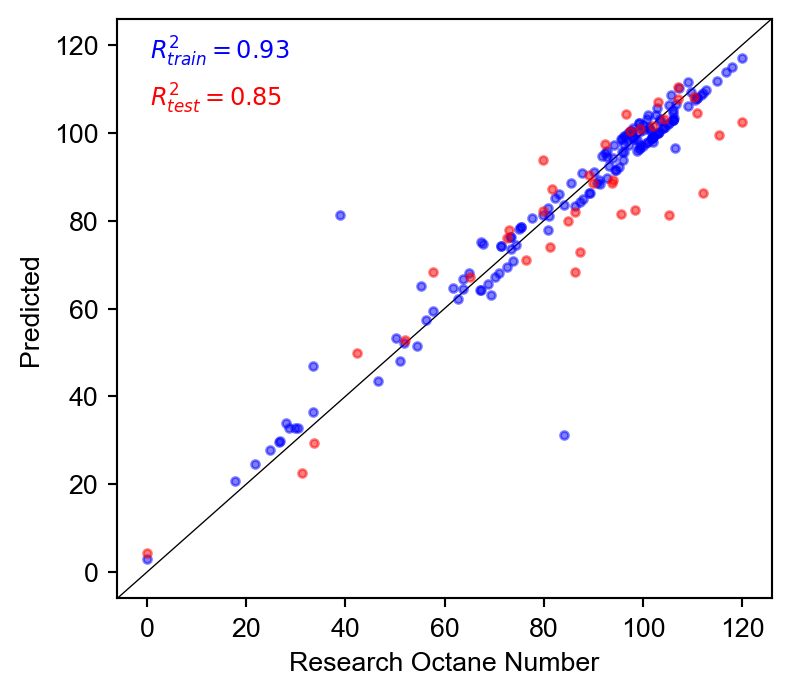

In [17]:
regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Research Octane Number", savetitle="../results/macaw/RON.svg") 

As another example, we also train a relevance vector regressor (RVR) using the same MACAW features. This type of model can deal automatically with the regularization (`gamma='scale'`) and provide uncertainty estimates of the predictions. Information about this package can be found [here](https://sklearn-rvm.readthedocs.io/en/latest/index.html).

In [18]:
regr = EMRVR(kernel='rbf', gamma=8)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred, y_train_std = regr.predict(X_train, return_std=True)

# Test set predictions
y_test_pred, y_test_std = regr.predict(X_test, return_std=True)

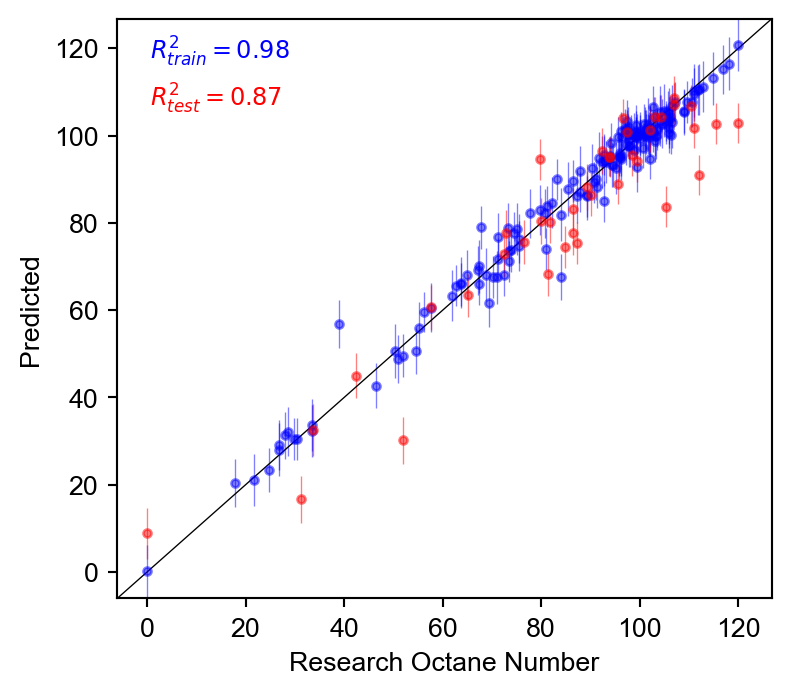

In [19]:
# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            y_train_std=y_train_std, y_test_std=y_test_std, xlabel="Research Octane Number") 

Let us save the MACAW embedder and the RON model for later use in Jupyter Notebook 3.

In [20]:
data = (mcw, regr)

picklefile = open("../results/macaw/RON_model_RVR.pickle", 'wb')
pickle.dump(data, picklefile, protocol=pickle.HIGHEST_PROTOCOL)
picklefile.close()

## Cetane Number (CN)

Here we demonstrate how MACAW embeddings can help model cetane numbers. We will use a similar approach as above. First we load the data:

In [21]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


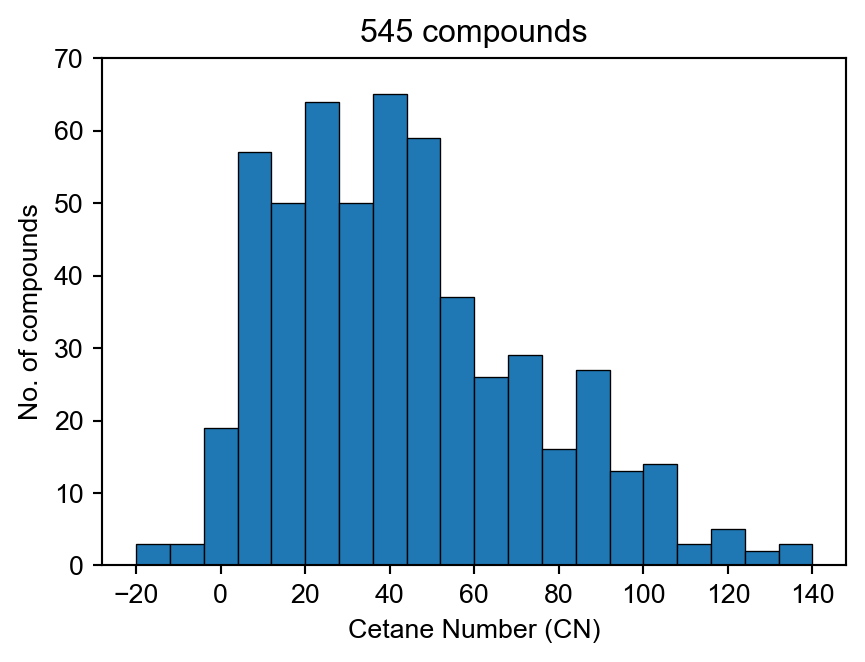

In [22]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [23]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

We compute the MACAW embeddings:

In [24]:
mcw = MACAW_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100, random_state=77)

Problem type identified as regression
morgan2 & tanimoto: 0.571
morgan3 & tanimoto: 0.621
rdk5 & tanimoto: 0.412
rdk7 & tanimoto: 0.484
featmorgan2 & tanimoto: 0.431
featmorgan3 & tanimoto: 0.548
maccs & tanimoto: 0.509
avalon & tanimoto: 0.449
atompairs & tanimoto: 0.713
torsion & tanimoto: 0.615
pattern & tanimoto: 0.602
secfp6 & tanimoto: 0.546
layered & tanimoto: 0.501
atompairs & tanimoto: 0.713
atompairs & cosine: 0.720
atompairs & dice: 0.724
atompairs & sokal: 0.716
atompairs & kulczynski: 0.723
atompairs & mcconnaughey: 0.723
atompairs & braun-blanquet: 0.695
atompairs & rogot-goldberg: 0.722
atompairs & asymmetric: 0.687
atompairs & manhattan: 0.689
atompairs & blay-roger: 0.697
Setting recommended combination: atompairs & dice


Let us train a SVR model. We explore a few different values of the regularization constant `C` to improve its performance:

In [25]:
X_train = mcw.transform(smi_train)

for C in [30,50,100,300]:
    regr = SVR(kernel='rbf', C=C, epsilon=5)
    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.7851343658000911
0.7939558773488526
0.8021084138385313
0.8115823244422276


We train the final model with the best value `C=100` and validate the model performance on the test set:

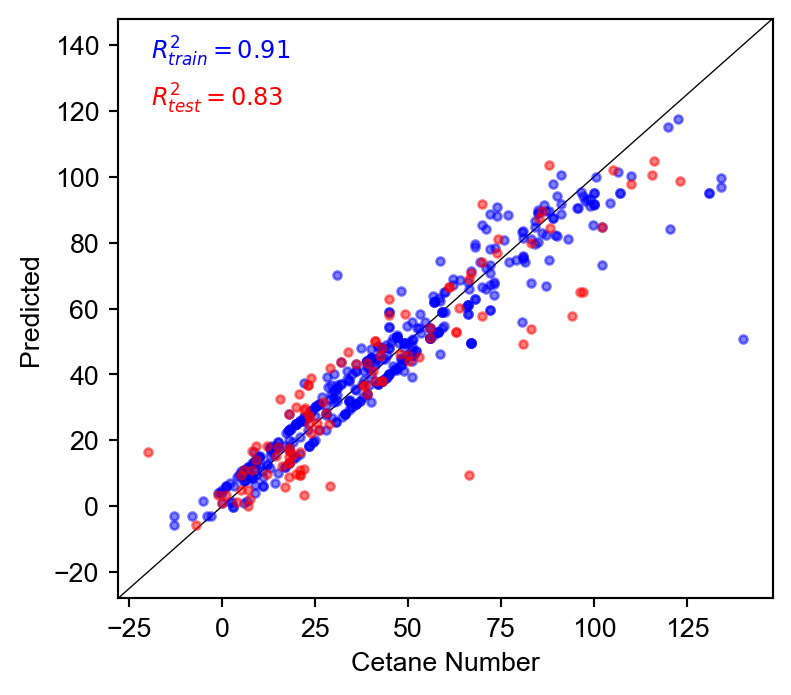

In [26]:
regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, xlabel="Cetane Number", 
            y_test=y_test_pred, savetitle="../results/macaw/CN.svg") 

## Yield Sooting Index

Here we demonstrate how MACAW embeddings can help model Yield Soot Index (YSI), another complex molecular property.

In [39]:
df = pd.read_csv('../data/data_YSI.csv')
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


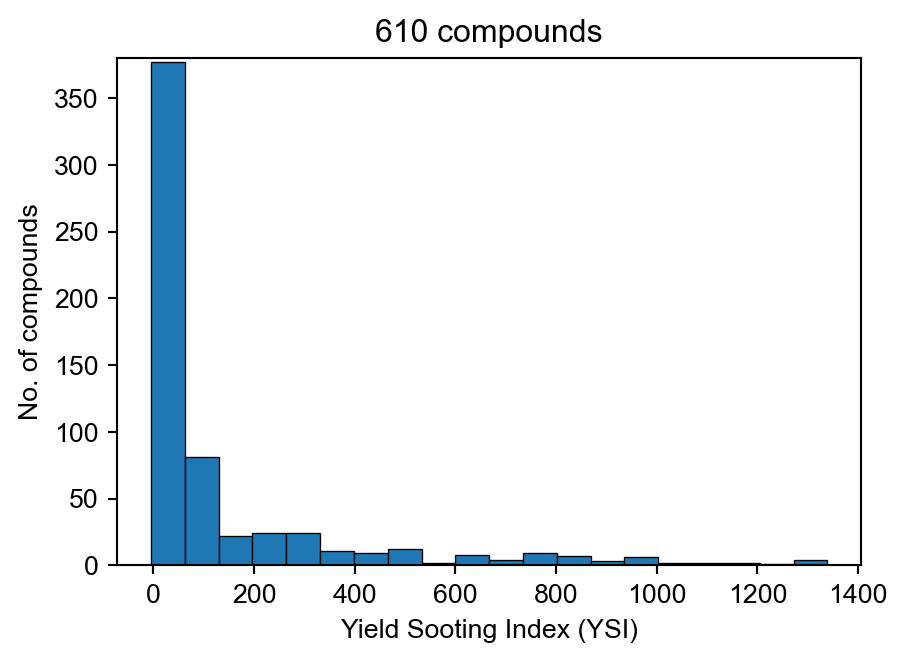

In [40]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In this case, we see that the data distribution is very skewed. There are different approaches to deal with this, for example, we could transform the YSI values to  get a more uniform distribution. For illustration purposes, we will work with the data as is.

We apply a stratified sampling to hold out the validation set in this case:

In [41]:
bins = np.linspace(min(Y), max(Y), 10+1)
Y_binned = np.digitize(Y, bins[:-1])
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42, stratify=Y_binned)

Next we compute the MACAW embeddings using only training data. In a case like this, it is recommended to provide property information (`Y=y_train`) to achieve a more balanced choice of landmarks. 

In [42]:
mcw = MACAW_optimus(smi_train, y_train, random_state=29)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: atompairs & blay-roger


Since we did not transform the YSI data, we may want to introduce sample weights in the model. The way we do it here is by binning molecules as a function of YSI values, and then 
setting the weight of each datum in inverse proportion to the number of molecules in the bucket.

In [43]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

Now we can train the model. As in the other regression examples, we use a SVR. For this model, the weights provided will scale the regularization in different regions of space, in relation to the global regularization set by `C`.

In [44]:
for C in [30,100,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=20)
 
    scores = cross_val_score(regr, X_train, y_train, cv=5, fit_params={'sample_weight': weights})
    print(scores.mean())

0.7387942650625369
0.7988074149878522
0.8324962865373845
0.8416079878401623


And we train the final model:

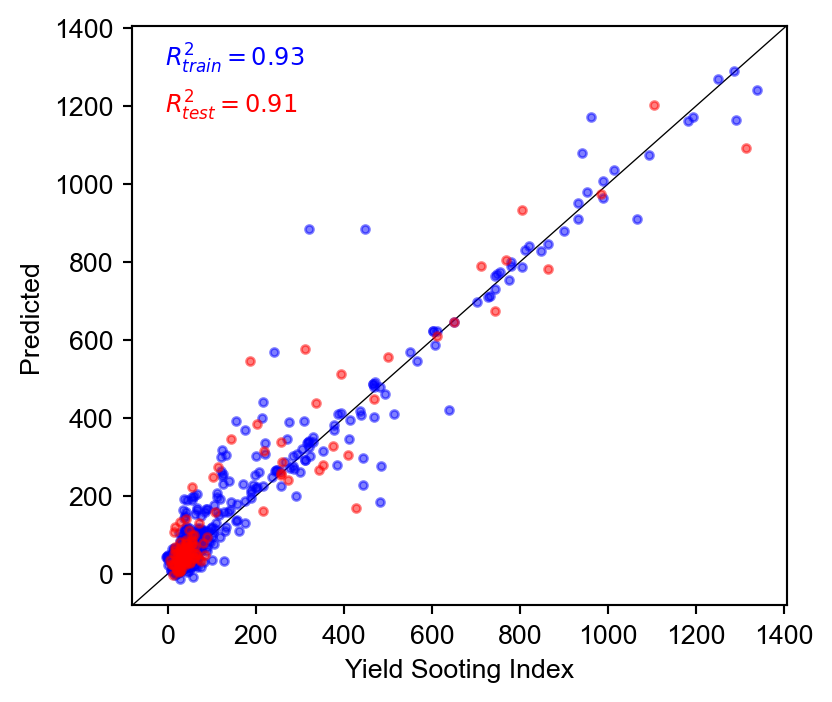

In [45]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index", savetitle="../results/macaw/YSI.svg") 

##  Melting Point (MP)

In [46]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


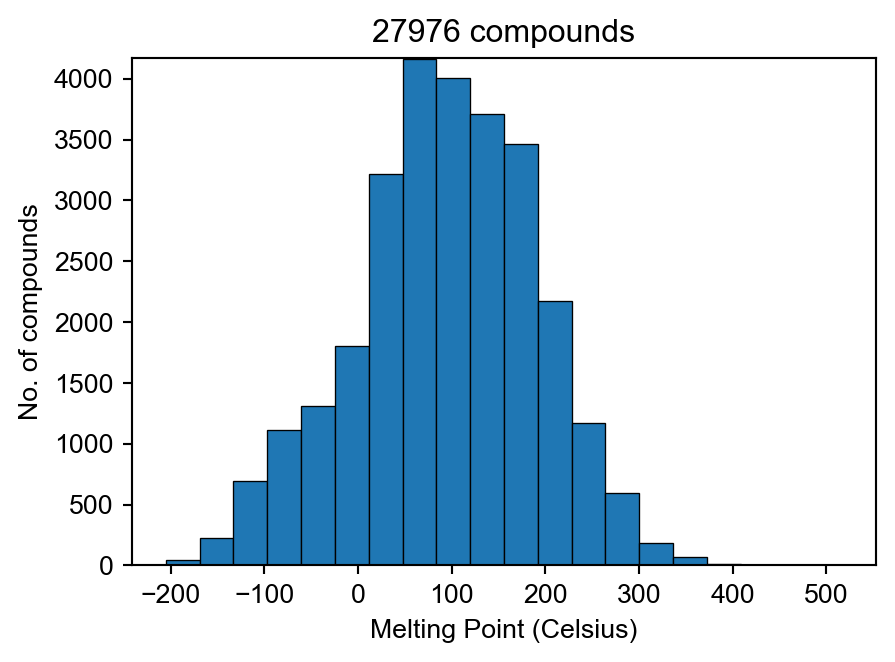

In [47]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [48]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

22380


In [49]:
mcw = MACAW(type_fp='maccs', metric='tanimoto', n_landmarks=100, random_state=51)
mcw.fit(smi_train, Y=y_train)

In [50]:
X_train = mcw.transform(smi_train)

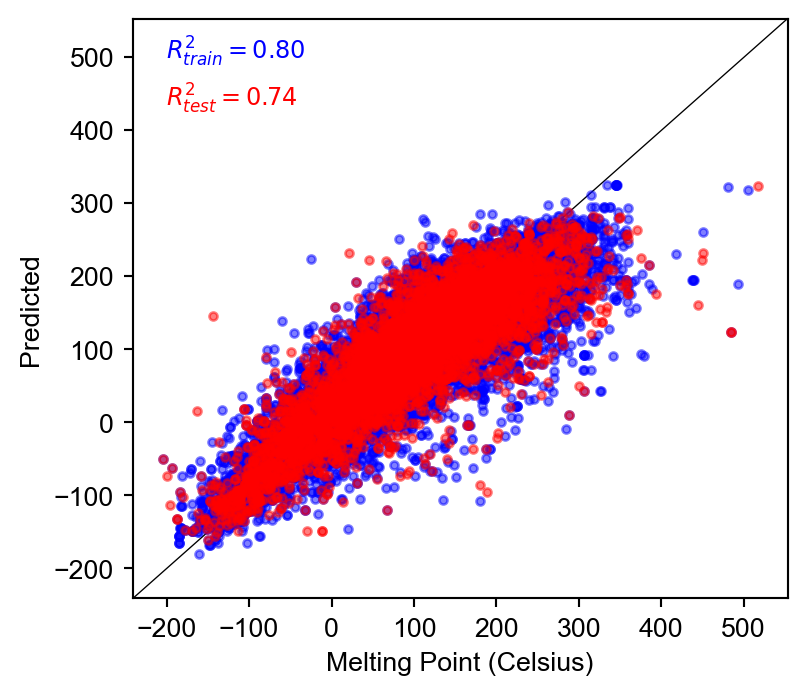

In [51]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../results/macaw/MP.svg") 

MACAW also allows concatenating fingerprints, which may improve performance in some cases:

In [52]:
mcw = MACAW(n_components=20, n_landmarks=200, type_fp='maccs+atompairs', metric='tanimoto', random_state=51)
mcw.fit(smi_train, Y=y_train)

In [53]:
X_train = mcw.transform(smi_train)

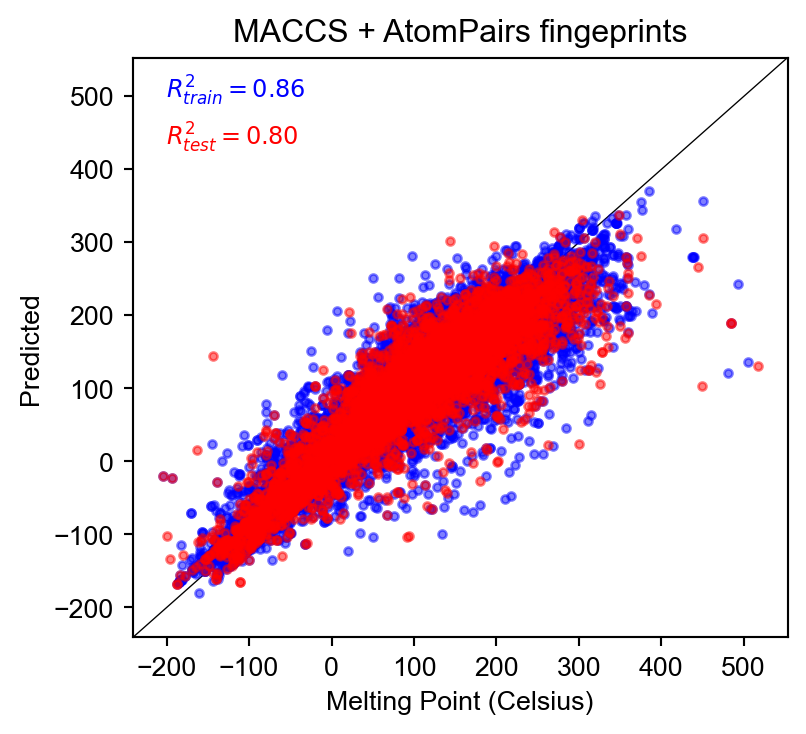

In [54]:
regr = SVR(kernel='rbf', C=500, epsilon=20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Melting Point (Celsius)", title="MACCS + AtomPairs fingeprints", savetitle="../results/macaw/MP_2.svg") 

## Flash Point (FP)

In [56]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


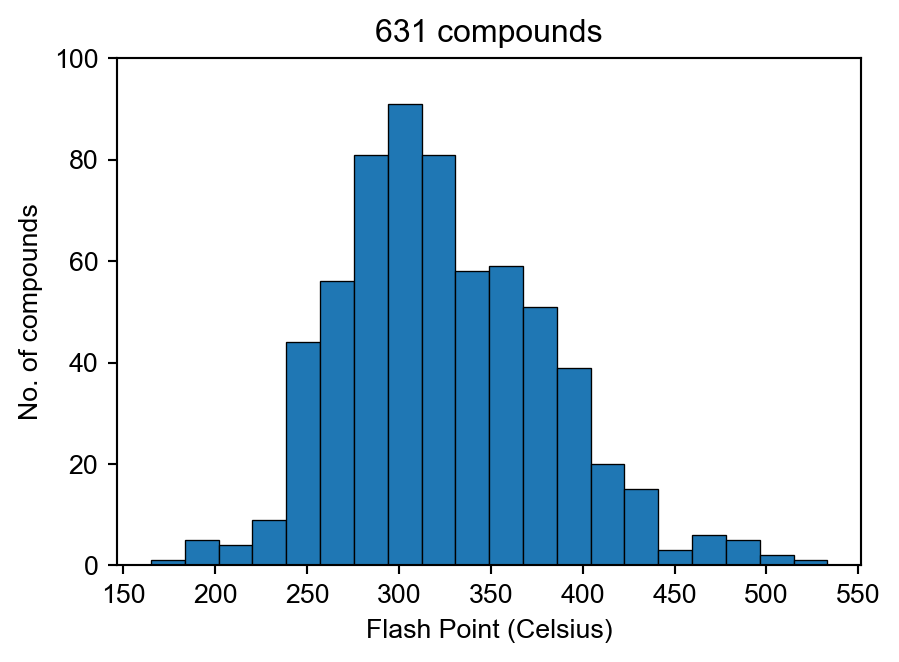

In [57]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [58]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

504


In [59]:
mcw = MACAW_optimus(smi_train, y_train, C=100, random_state=521, exhaustiveness=3, verbose=True)

X_train = mcw.transform(smi_train)

Problem type identified as regression
morgan2 & tanimoto: 0.633
morgan2 & cosine: 0.635
morgan2 & dice: 0.639
morgan3 & tanimoto: 0.676
morgan3 & cosine: 0.684
morgan3 & dice: 0.692
rdk5 & tanimoto: 0.623
rdk5 & cosine: 0.634
rdk5 & dice: 0.639
rdk7 & tanimoto: 0.696
rdk7 & cosine: 0.711
rdk7 & dice: 0.726
featmorgan2 & tanimoto: 0.582
featmorgan2 & cosine: 0.583
featmorgan2 & dice: 0.582
featmorgan3 & tanimoto: 0.669
featmorgan3 & cosine: 0.660
featmorgan3 & dice: 0.666
maccs & tanimoto: 0.688
maccs & cosine: 0.666
maccs & dice: 0.669
avalon & tanimoto: 0.583
avalon & cosine: 0.583
avalon & dice: 0.605
atompairs & tanimoto: 0.782
atompairs & cosine: 0.796
atompairs & dice: 0.808
torsion & tanimoto: 0.514
torsion & cosine: 0.512
torsion & dice: 0.530
pattern & tanimoto: 0.831
pattern & cosine: 0.840
pattern & dice: 0.836
secfp6 & tanimoto: 0.605
secfp6 & cosine: 0.625
secfp6 & dice: 0.625
layered & tanimoto: 0.714
layered & cosine: 0.709
layered & dice: 0.705
pattern+atompairs & tanimo

In [60]:
for C in [50,100,200,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=5)

    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.8709813348977355
0.8908144245010874
0.8994101165661498
0.9021613657149896
0.8991172221751811


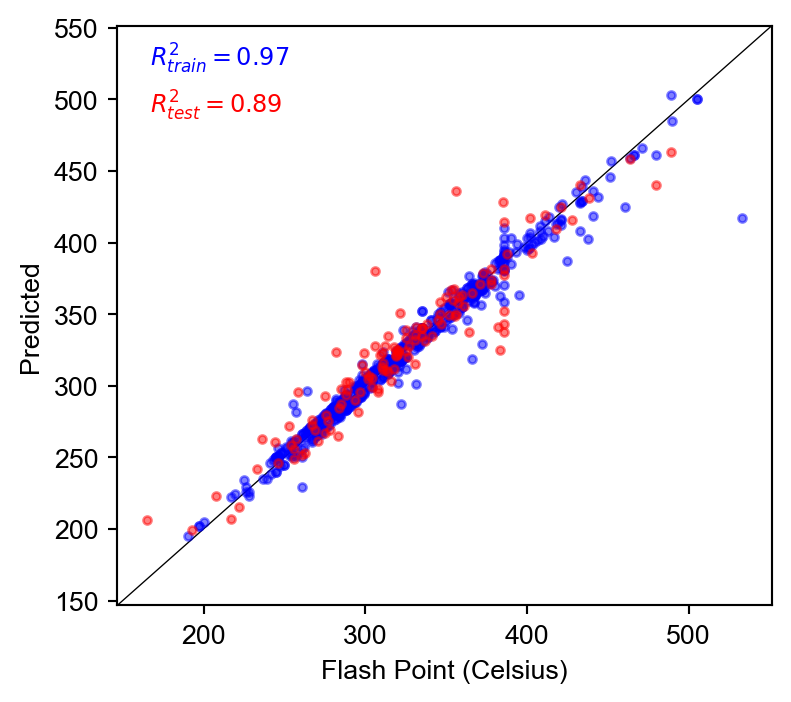

In [61]:
regr = SVR(kernel='rbf', C=300, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../results/macaw/FP.svg") 